In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import pickle
import random
import io
import os

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

PAD_IDX = 0
UNK_IDX = 1

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

VOCAB_SIZE = 50000
NUM_CLASSES = 3
NUM_LAYERS = 1
BIDIRECTIONAL = True
NUM_DIRECTIONS = 2 if BIDIRECTIONAL else 1
EMB_HIDDEN_SIZE, CLASS_HIDDEN_SIZE = 256, 512

BATCH_SIZE = 32
LR = 3e-4
N_EPOCHS = 10
N_EPOCHS_FINETUNE = 2

# 3.1 Training on SNLI

## 3.1.1 Training RNN, CNN on Fixed Hyperparameters

In [2]:
snli_train_data = pd.read_csv('data/snli_train.tsv', sep='\t')
snli_val_data = pd.read_csv('data/snli_val.tsv', sep='\t')

In [3]:
snli_train_data.head()

,sentence1,sentence2,label
0,A young girl in a pink shirt sitting on a dock...,A young girl watching the sunset over the water .,neutral
1,A woman is smiling while the man next to her i...,Two people are next to each other .,entailment
2,"Across the river , you can see a large building .",The large building is full of apartments and t...,neutral
3,a man in white shorts and a black shirt is par...,A man is riding a jetski on the ocean .,contradiction
4,Four black dogs run together on bright green g...,Four dogs are preparing to be launched into sp...,contradiction


In [4]:
snli_train_data.shape

(100000, 3)

In [5]:
snli_train_data.head()

,sentence1,sentence2,label
0,A young girl in a pink shirt sitting on a dock...,A young girl watching the sunset over the water .,neutral
1,A woman is smiling while the man next to her i...,Two people are next to each other .,entailment
2,"Across the river , you can see a large building .",The large building is full of apartments and t...,neutral
3,a man in white shorts and a black shirt is par...,A man is riding a jetski on the ocean .,contradiction
4,Four black dogs run together on bright green g...,Four dogs are preparing to be launched into sp...,contradiction


In [6]:
def prepare_data(data):
    df = data.copy()
    df['label'] = df['label'].map({'contradiction': 0, 'neutral': 1, 'entailment': 2})
    df['sentence1'] = df['sentence1'].str.split()
    df['sentence2'] = df['sentence2'].str.split()
    return df

In [7]:
def load_vectors(f_name, vocabulary):
    f_in = io.open(f_name, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, f_in.readline().split())
    vectors = {}
    for line in f_in:
        tokens = line.strip().split(' ')
        if tokens[0] in vocabulary:
            vectors[tokens[0]] = list(map(float, tokens[1:]))
    return vectors

In [8]:
def build_vocabulary(train_data, vocab_size):
    '''
    Returns:
    id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    token2id: dictionary where keys represent tokens and corresponding values represent indices
    '''
    print('Building vocabulary... ', end='', flush=True)
    all_tokens = []
    for row in (train_data['sentence1']+train_data['sentence2']).iteritems():
        all_tokens += row[1]
    vocabulary, count = zip(*Counter(all_tokens).most_common(vocab_size))
    print('Done.')
    print('Loading vocabulary vectors... ', end='', flush=True)
    vectors = load_vectors('data/wiki-news-300d-1M.vec', vocabulary)
    vocabulary = [word for word in vocabulary if word in vectors]
    print('Done.')
    id2token = list(vocabulary)
    token2id = dict(zip(vocabulary, range(2, 2+len(vocabulary))))
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token, vectors

def preprocess_data(data, dataset, vocab_size=50000):
    data = prepare_data(data)
    if dataset == 'train':
        token2id, id2token, vectors = build_vocabulary(data, vocab_size)
        return data, token2id, id2token, vectors
    return data

In [9]:
# train_data, token2id, id2token, vectors = preprocess_data(snli_train_data, 'train', VOCAB_SIZE)
# val_data = preprocess_data(snli_val_data, 'val')

# pickle.dump(vectors, open('data/vectors.pkl', 'wb'))
# pickle.dump(token2id, open('data/token2id.pkl', 'wb'))
# pickle.dump(id2token, open('data/id2token.pkl', 'wb'))

In [10]:
train_data = prepare_data(snli_train_data)
val_data = prepare_data(snli_val_data)
vectors = pickle.load(open('data/vectors.pkl', 'rb'))
id2token = pickle.load(open('data/id2token.pkl', 'rb'))
token2id = pickle.load(open('data/token2id.pkl', 'rb'))

In [11]:
print("Total number of tokens in train dataset = {}".format(len(token2id)))

Total number of tokens in train dataset = 22059


In [12]:
# Check the dictionary by loading random token from it
random_token_id = np.random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]
print("Token id: {}; Token: {}".format(random_token_id, id2token[random_token_id]))
print("Token: {}; Token id: {}".format(random_token, token2id[random_token]))

Token id: 4055; Token: walker
Token: walker; Token id: 4055


In [13]:
def get_max_sentence_length(train_data, q=0.95):
    max_sent1_len = train_data['sentence1'].str.len().quantile(q)
    max_sent2_len = train_data['sentence2'].str.len().quantile(q)
    return int(max(max_sent1_len, max_sent2_len))

In [14]:
MAX_SENT_LENGTH = get_max_sentence_length(train_data)
MAX_SENT_LENGTH

25

In [132]:
train_data['sentence1'].str.len().describe()

count    100000.000000
mean         14.038630
std           6.009452
min           2.000000
25%          10.000000
50%          13.000000
75%          17.000000
max          82.000000
Name: sentence1, dtype: float64

In [133]:
train_data['sentence2'].str.len().describe()

count    100000.000000
mean          8.242020
std           3.202772
min           1.000000
25%           6.000000
50%           8.000000
75%          10.000000
max          41.000000
Name: sentence2, dtype: float64

In [15]:
class SNLIDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data, token2id, max_sent_length):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.x1, self.x2, self.y = data['sentence1'].values, data['sentence2'].values, data['label'].values
        self.max_sent_length = max_sent_length
        assert (len(self.x1) == len(self.x2) == len(self.y))
        self.token2id = token2id

    def __len__(self):
        return len(self.y)

    def __getitem__(self, row):
        """
        Triggered when you call dataset[i]
        """
        label = self.y[row]
        x1_word_idx, x2_word_idx = [], []
        x1_mask, x2_mask = [], []
        
        for word in self.x1[row][:self.max_sent_length]:
            if word in self.token2id.keys():
                x1_word_idx.append(self.token2id[word])
                x1_mask.append(0)
            else:
                x1_word_idx.append(UNK_IDX)
                x1_mask.append(1)
                
        for word in self.x2[row][:self.max_sent_length]:
            if word in self.token2id.keys():
                x2_word_idx.append(self.token2id[word])
                x2_mask.append(0)
            else:
                x2_word_idx.append(UNK_IDX)
                x2_mask.append(1)
        
        x1_list = [x1_word_idx, x1_mask, len(x1_word_idx)]
        x2_list = [x2_word_idx, x2_mask, len(x2_word_idx)]
        return x1_list + x2_list + [label]

In [16]:
def snli_collate_func(batch, max_sent_length):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    x1_data, x2_data = [], []
    x1_mask, x2_mask = [], []
    x1_lengths, x2_lengths = [], []
    labels = []

    for datum in batch:
        x1_lengths.append(datum[2])
        x2_lengths.append(datum[5])
        labels.append(datum[6])
        
        # Padding
        x1_data_padded = np.pad(np.array(datum[0]), pad_width=((0, max_sent_length-datum[2])),
                                mode="constant", constant_values=0)
        x1_data.append(x1_data_padded)
        
        x1_mask_padded = np.pad(np.array(datum[1]), pad_width=((0, max_sent_length-datum[2])),
                                mode="constant", constant_values=0)
        x1_mask.append(x1_mask_padded)
        
        x2_data_padded = np.pad(np.array(datum[3]), pad_width=((0, max_sent_length-datum[5])),
                                mode="constant", constant_values=0)
        x2_data.append(x2_data_padded)
        
        x2_mask_padded = np.pad(np.array(datum[4]), pad_width=((0, max_sent_length-datum[5])),
                               mode="constant", constant_values=0)
        x2_mask.append(x2_mask_padded)
        
    ind_dec_order = np.argsort(x1_lengths)[::-1]
    
    x1_data = np.array(x1_data)[ind_dec_order]
    x2_data = np.array(x2_data)[ind_dec_order]
    
    x1_mask = np.array(x1_mask)[ind_dec_order].reshape(len(batch), -1, 1)
    x2_mask = np.array(x2_mask)[ind_dec_order].reshape(len(batch), -1, 1)
    
    x1_lengths = np.array(x1_lengths)[ind_dec_order]
    x2_lengths = np.array(x2_lengths)[ind_dec_order]
    
    labels = np.array(labels)[ind_dec_order]
    
    x1_list = [torch.from_numpy(x1_data), torch.from_numpy(x1_mask).float(), x1_lengths]
    x2_list = [torch.from_numpy(x2_data), torch.from_numpy(x2_mask).float(), x2_lengths]
        
    return x1_list + x2_list + [torch.from_numpy(labels)]

In [17]:
# Build train and validation dataloaders

train_dataset = SNLIDataset(train_data, token2id, MAX_SENT_LENGTH)
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          collate_fn=lambda b, max_sent_length=MAX_SENT_LENGTH: \
                              snli_collate_func(b, max_sent_length),
                          shuffle=True)

val_dataset = SNLIDataset(val_data, token2id, MAX_SENT_LENGTH)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        collate_fn=lambda b, max_sent_length=MAX_SENT_LENGTH: \
                            snli_collate_func(b, max_sent_length),
                        shuffle=False)

In [18]:
class GRUEncoder(nn.Module):
    def __init__(self, hidden_size, num_layers, emb_weights, vocab_size, bidirectional=False):
        '''
        params:
            hidden_size: hidden Size of layer in GRU
            num_layers: number of layers in GRU
            output_size: dimension of output
            vocab_size: vocabulary size
            bidirectional: use bidirectional GRU
        '''
        super(GRUEncoder, self).__init__()
        
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding(vocab_size, 300, padding_idx=PAD_IDX)
        self.gru = nn.GRU(300, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.num_directions = 2 if bidirectional else 1
        self.embedding.weight.data.copy_(torch.from_numpy(emb_weights))

    def forward(self, x, mask, lengths):
        true2sorted = sorted(range(len(lengths)), key=lambda x: -lengths[x])
        sorted2true = sorted(range(len(lengths)), key=lambda x: true2sorted[x])
        x = x[true2sorted]
        mask = mask[true2sorted]
        lengths = lengths[true2sorted]
        
        batch_size, seq_len = x.size()
        
        # reset hidden state
        self.hidden = self._init_hidden(batch_size)
        
        # get embedding of words
        embed = self.embedding(x)
        
        # mask out all embeddings other than <unk> token to freeze their weights
        embed = mask*embed + (1-mask)*embed.clone().detach()
        
        # pack padded sequence
        embed = torch.nn.utils.rnn.pack_padded_sequence(embed, lengths, batch_first=True)
        
        # forward prop though GRU
        gru_out, self.hidden = self.gru(embed, self.hidden)
        
        # undo packing
        gru_out, _ = torch.nn.utils.rnn.pad_packed_sequence(gru_out, batch_first=True)
        
        # (batch_size, seq_len, num_directions*hidden_size) -> (batch_size, seq_len, num_directions, hidden_size)
        gru_out = gru_out.view(batch_size, -1, self.num_directions, self.hidden_size)
        
        # sum hidden activations of GRU across time
        gru_out = torch.sum(gru_out, dim=1)
        
        # concat all directions along the hidden dimension
        gru_out = torch.cat([gru_out[:,i,:] for i in range(self.num_directions)], dim=1)
        
        # get data back in original order of batches
        gru_out = gru_out[sorted2true]
        
        return gru_out
    
    def _init_hidden(self, batch_size):
        hidden = torch.randn(self.num_directions*self.num_layers, batch_size, self.hidden_size).to(DEVICE)
        return hidden

In [19]:
class ClassificationNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes=3, num_directions=1, mode='cat', drop_rate=0.5):
        super(ClassificationNetwork, self).__init__()
        
        self.mode = mode
        
        # Fully connected and ReLU layers
        if mode == 'cat':
            self.fc1 = nn.Linear(2*input_size*num_directions, hidden_size)
        elif mode in ['elementwise_mult', 'sum']:
            self.fc1 = nn.Linear(input_size*num_directions, hidden_size)
        else:
            raise ValueError('Invalid arugment "{}" for mode!'.format(mode))
        
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=drop_rate)

        # Initialize weights
        self._init_weights()

    def forward(self, embedding_output1, embedding_output2):
        if self.mode == 'cat':
            input = torch.cat([embedding_output1, embedding_output2], dim=1)
        elif self.mode == 'elementwise_mult':
            input = embedding_output1 * embedding_output2
        elif self.mode == 'sum':
            input = embedding_output1 + embedding_output2
        
        input = input.view(input.size(0), -1) # Reshape input to batch_size x num_inputs
        output = self.fc1(input)
        output = self.relu(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.uniform_(m.bias)

In [20]:
# Initialize weights matrix
def init_embedding_weights(vectors, token2id, id2token):
    weights = np.zeros((len(token2id), 300))
    for idx in range(2, len(vectors)):
        weights[idx] = np.array(vectors[id2token[idx]])
    np.random.seed(1337)
    weights[1] = np.random.randn(300)
    return weights

In [21]:
def train(embedding_network, classification_network, dataloader, criterion, optimizer, epoch):
    embedding_network.train()
    classification_network.train()
    
    loss_hist = []
    
    for batch_idx, (x1, x1_mask, x1_lengths, x2, x2_mask, x2_lengths, y) in enumerate(dataloader):
        x1, x1_mask, x2, x2_mask, y = x1.to(DEVICE), x1_mask.to(DEVICE), x2.to(DEVICE), x2_mask.to(DEVICE), y.to(DEVICE)
        
        embedding_network.train()
        classification_network.train()
        
        optimizer.zero_grad()
        
        # Forward pass
        embedding_output1 = embedding_network(x1, x1_mask, x1_lengths)
        embedding_output2 = embedding_network(x2, x2_mask, x2_lengths)
        classification_output = classification_network(embedding_output1, embedding_output2)
        
        # Compute loss, back-prop, and take step
        loss = criterion(classification_output, y)
        loss.backward()
        optimizer.step()

        # Accurately compute loss, because of different batch size
        loss_train = loss.item() * len(x1) / len(dataloader.dataset)
        loss_hist.append(loss_train)

        if (batch_idx+1) % (len(dataloader.dataset)//(10*y.shape[0])) == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx+1) * y.shape[0], len(dataloader.dataset),
                100. * (batch_idx+1) / len(dataloader), loss.item()))

    optimizer.zero_grad()
    return loss_hist

In [22]:
def test(embedding_network, classification_network, dataloader, criterion):
    embedding_network.eval()
    classification_network.eval()
    
    loss_hist = []
    y_ls = []
    output_ls = []
    
    with torch.no_grad():
        for batch_idx, (x1, x1_mask, x1_lengths, x2, x2_mask, x2_lengths, y) in enumerate(dataloader):
            x1, x1_mask, x2, x2_mask, y = x1.to(DEVICE), x1_mask.to(DEVICE), x2.to(DEVICE), x2_mask.to(DEVICE), y.to(DEVICE)
            
            embedding_output1 = embedding_network(x1, x1_mask, x1_lengths)
            embedding_output2 = embedding_network(x2, x2_mask, x2_lengths)
            classification_output = classification_network(embedding_output1, embedding_output2)
            
            loss = criterion(classification_output, y)

            # Accurately compute loss, because of different batch size
            loss_test = loss.item() / len(dataloader.dataset)
            loss_hist.append(loss_test)

            output_ls.append(classification_output)
            y_ls.append(y)
    return loss_hist, torch.cat(output_ls, dim=0), torch.cat(y_ls, dim=0)

In [23]:
def accuracy(embedding_network, classification_network, dataloader, criterion):
    _, y_predicted, y_true = test(
        embedding_network=embedding_network,
        classification_network=classification_network,
        dataloader=dataloader,
        criterion=criterion
    )

    y_predicted = y_predicted.max(1)[1]
    return 100*y_predicted.eq(y_true.data.view_as(y_predicted)).float().mean().item()

In [24]:
def run_training(train_loader, val_loader, embedding_network, classification_network, \
                 criterion_train, criterion_test, optimizer, n_epochs):
    train_loss_history, train_accuracy_history = [], []
    val_loss_history, val_accuracy_history = [], []
    stop_epoch = n_epochs

    for epoch in range(1, n_epochs+1):
        try:
            train_losses = train(
                embedding_network=embedding_network,
                classification_network=classification_network,
                criterion=criterion_train,
                dataloader=train_loader,
                optimizer=optimizer,
                epoch=epoch
            )

            val_losses, val_pred, val_true = test(
                embedding_network=embedding_network,
                classification_network=classification_network,
                dataloader=val_loader,
                criterion=criterion_test
            )

            accuracy_train = accuracy(embedding_network, classification_network, train_loader, criterion_test)
            accuracy_val = accuracy(embedding_network, classification_network, val_loader, criterion_test)
            train_loss_history.extend(train_losses)
            val_loss_history.extend(val_losses)
            train_accuracy_history.append(accuracy_train)
            val_accuracy_history.append(accuracy_val)

            print('TRAIN Epoch: {}\tAverage loss: {:.4f}, Accuracy: {:.0f}%'.format(epoch, np.mean(train_losses), accuracy_train))
            print('VAL   Epoch: {}\tAverage loss: {:.4f}, Accuracy: {:.0f}%\n'.format(epoch, np.mean(val_losses), accuracy_val))
        except KeyboardInterrupt:
            # Save the model checkpoints
            print('Keyboard Interrupted!')
            stop_epoch = epoch-1
            break
    
    return embedding_network, classification_network, optimizer, train_loss_history, \
            val_loss_history, train_accuracy_history, val_accuracy_history, stop_epoch

In [ ]:
WEIGHTS = init_embedding_weights(vectors, token2id, id2token)

# Encoder and Classification Networks
embedding_network_gru = GRUEncoder(hidden_size=EMB_HIDDEN_SIZE, num_layers=NUM_LAYERS, emb_weights=WEIGHTS, vocab_size=len(token2id), bidirectional=BIDIRECTIONAL).to(DEVICE)
classification_network_gru = ClassificationNetwork(EMB_HIDDEN_SIZE, CLASS_HIDDEN_SIZE, NUM_CLASSES, NUM_DIRECTIONS).to(DEVICE)

# Criterion and Optimizer
criterion_train = nn.CrossEntropyLoss()
criterion_test = nn.CrossEntropyLoss(reduction='sum')
optimizer_gru = torch.optim.Adam(list(embedding_network_gru.parameters())+list(classification_network_gru.parameters()), lr=LR)

In [ ]:
embedding_network_gru, classification_network_gru, optimizer_gru, train_loss_history_gru, val_loss_history_gru, \
    train_accuracy_history_gru, val_accuracy_history_gru, stop_epoch_gru = \
    run_training(train_loader, val_loader, embedding_network_gru, classification_network_gru, \
                 criterion_train, criterion_test, optimizer_gru, N_EPOCHS)

In [ ]:
gru_state_dict = {
    'embedding_state_dict': embedding_network_gru.state_dict(),
    'classification_state_dict': classification_network_gru.state_dict(),
    'optimizer': optimizer_gru.state_dict(),
    'train_loss_history': train_loss_history_gru,
    'val_loss_history': val_loss_history_gru,
    'train_accuracy_history': train_accuracy_history_gru,
    'val_accuracy_history': val_accuracy_history_gru,
    'stop_epoch': stop_epoch_gru
}

torch.save(gru_state_dict, os.path.join('checkpoints/gru_state_dict.pkl'))

In [ ]:
# Load already dumped models

WEIGHTS = init_embedding_weights(vectors, token2id, id2token)

# Encoder and Classification Networks
embedding_network_gru = GRUEncoder(hidden_size=EMB_HIDDEN_SIZE, num_layers=NUM_LAYERS, emb_weights=WEIGHTS, vocab_size=len(token2id), bidirectional=BIDIRECTIONAL)
classification_network_gru = ClassificationNetwork(EMB_HIDDEN_SIZE, CLASS_HIDDEN_SIZE, NUM_CLASSES, NUM_DIRECTIONS)

# Criterion and Optimizer
criterion_train = nn.CrossEntropyLoss()
criterion_test = nn.CrossEntropyLoss(reduction='sum')
optimizer_gru = torch.optim.Adam(list(embedding_network_gru.parameters())+list(classification_network_gru.parameters()), lr=LR)

gru_state_dict = torch.load('checkpoints/gru_state_dict.pkl')

embedding_network_gru.load_state_dict(gru_state_dict['embedding_state_dict'])
classification_network_gru.load_state_dict(gru_state_dict['classification_state_dict'])
optimizer_gru.load_state_dict(gru_state_dict['optimizer'])
train_loss_history_gru = gru_state_dict['train_loss_history']
val_loss_history_gru = gru_state_dict['val_loss_history']
train_accuracy_history_gru = gru_state_dict['train_accuracy_history']
val_accuracy_history_gru = gru_state_dict['val_accuracy_history']
stop_epoch_gru = gru_state_dict['stop_epoch']

embedding_network_gru = embedding_network_gru.to(DEVICE)
classification_network_gru = classification_network_gru.to(DEVICE)
for state in optimizer_gru.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(DEVICE)

In [25]:
class CNNEncoder(nn.Module):
    def __init__(self, hidden_size, vocab_size, emb_weights, kernel_size=3):

        super(CNNEncoder, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, 300, padding_idx=PAD_IDX)
    
        self.conv1 = nn.Conv1d(300, hidden_size, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU(inplace=True)
        
        self.embedding.weight.data.copy_(torch.from_numpy(emb_weights))

    def forward(self, x, mask, lengths):
        batch_size, seq_len = x.size()
        
        embed = self.embedding(x)
        
        # mask out all embeddings other than <unk> token to freeze their weights
        embed = mask*embed + (1-mask)*embed.clone().detach()
        
        hidden = self.conv1(embed.transpose(1,2)).transpose(1,2)
        hidden = self.relu(hidden.contiguous().view(-1, hidden.size(-1)))
        hidden = hidden.view(batch_size, seq_len, hidden.size(-1))
        
        hidden = self.conv2(hidden.transpose(1,2)).transpose(1,2)
        hidden = self.relu(hidden.contiguous().view(-1, hidden.size(-1)))
        hidden = hidden.view(batch_size, seq_len, hidden.size(-1))
        
        out = torch.sum(hidden, dim=1)
        
        return out

In [ ]:
WEIGHTS = init_embedding_weights(vectors, token2id, id2token)

# Encoder and Classification Networks
embedding_network_cnn = CNNEncoder(hidden_size=EMB_HIDDEN_SIZE, vocab_size=len(token2id), emb_weights=WEIGHTS).to(DEVICE)
classification_network_cnn = ClassificationNetwork(EMB_HIDDEN_SIZE, CLASS_HIDDEN_SIZE, NUM_CLASSES, mode='elementwise_mult').to(DEVICE)

# Criterion and Optimizer
criterion_train = nn.CrossEntropyLoss()
criterion_test = nn.CrossEntropyLoss(reduction='sum')
optimizer_cnn = torch.optim.Adam(list(embedding_network_cnn.parameters())+list(classification_network_cnn.parameters()), lr=LR)

In [ ]:
embedding_network_cnn, classification_network_cnn, optimizer_cnn, train_loss_history_cnn, val_loss_history_cnn, \
    train_accuracy_history_cnn, val_accuracy_history_cnn, stop_epoch_cnn = \
    run_training(train_loader, val_loader, embedding_network_cnn, classification_network_cnn, \
                 criterion_train, criterion_test, optimizer_cnn, N_EPOCHS)

In [ ]:
cnn_state_dict = {
    'embedding_state_dict': embedding_network_cnn.state_dict(),
    'classification_state_dict': classification_network_cnn.state_dict(),
    'optimizer': optimizer_cnn.state_dict(),
    'train_loss_history': train_loss_history_cnn,
    'val_loss_history': val_loss_history_cnn,
    'train_accuracy_history': train_accuracy_history_cnn,
    'val_accuracy_history': val_accuracy_history_cnn,
    'stop_epoch': stop_epoch_cnn
}

torch.save(cnn_state_dict, os.path.join('checkpoints/cnn_state_dict.pkl'))

In [ ]:
# Load already dumped models

WEIGHTS = init_embedding_weights(vectors, token2id, id2token)

# Encoder and Classification Networks
embedding_network_cnn = CNNEncoder(hidden_size=EMB_HIDDEN_SIZE, vocab_size=len(token2id), emb_weights=WEIGHTS)
classification_network_cnn = ClassificationNetwork(EMB_HIDDEN_SIZE, CLASS_HIDDEN_SIZE, NUM_CLASSES, mode='elementwise_mult')

# Criterion and Optimizer
criterion_train = nn.CrossEntropyLoss()
criterion_test = nn.CrossEntropyLoss(reduction='sum')
optimizer_cnn = torch.optim.Adam(list(embedding_network_cnn.parameters())+list(classification_network_cnn.parameters()), lr=LR)

cnn_state_dict = torch.load('checkpoints/cnn_state_dict.pkl')

embedding_network_cnn.load_state_dict(cnn_state_dict['embedding_state_dict'])
classification_network_cnn.load_state_dict(cnn_state_dict['classification_state_dict'])
optimizer_cnn.load_state_dict(cnn_state_dict['optimizer'])
train_loss_history_cnn = cnn_state_dict['train_loss_history']
val_loss_history_cnn = cnn_state_dict['val_loss_history']
train_accuracy_history_cnn = cnn_state_dict['train_accuracy_history']
val_accuracy_history_cnn = cnn_state_dict['val_accuracy_history']
stop_epoch_cnn = cnn_state_dict['stop_epoch']

embedding_network_cnn = embedding_network_cnn.to(DEVICE)
classification_network_cnn = classification_network_cnn.to(DEVICE)
for state in optimizer_cnn.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(DEVICE)

## 3.1.2 Hyperparameter Tuning

In [26]:
def get_trainable_params(network):
    return sum(p.numel() for p in network.parameters() if p.requires_grad)

In [27]:
def hyperparameter_tuning(snli_train_data, snli_val_data, params_dict, model='gru'):
    try:
        assert (model == 'gru' and 'kernel_size' not in params_dict.keys()) \
            or (model == 'cnn' and 'kernel_size' in params_dict.keys())
        
        cv_results = pd.DataFrame(columns=list(params_dict.keys()) + \
                                  ['train_loss_hist', 'val_loss_hist', 'train_accuracy_hist', \
                                   'val_accuracy_hist', 'num_params', 'max_val_accuracy'])
        
        params_df = pd.DataFrame([1]*len(params_dict['lr']), columns=['key'])
        for param in params_dict:
            params_dict[param]['key'] = 1
            params_df = pd.merge(params_df, params_dict[param], on='key')
        params_df = params_df.drop('key', axis=1).drop_duplicates()
        params_df = params_df.sort_values(by='vocab_size').reset_index(drop=True)

        print('Total number of configurations: {}'.format(len(params_df)))
        
        prev_vocab_size = None
        for row in params_df.iterrows():
            print('\n', params_df.iloc[row[0]:row[0]+1])

            lr, emb_hidden_size, class_hidden_size, vocab_size, max_sent_length, agg_mode, drop_rate = \
                row[1]['lr'], int(row[1]['emb_hidden_size']), int(row[1]['class_hidden_size']), \
                int(row[1]['vocab_size']), int(row[1]['max_sent_length']), \
                row[1]['agg_mode'], row[1]['dropout']
            
            if vocab_size == prev_vocab_size:
                train_data, prepare_data(snli_train_data)
                val_data = prepare_data(snli_val_data)
            else:
                train_data, token2id, id2token, vectors = preprocess_data(snli_train_data, 'train', vocab_size)
                val_data = preprocess_data(snli_val_data, 'val')
            
            print("Total number of tokens in train dataset = {}".format(len(token2id)))
            
            # Build train and validation dataloaders

            train_dataset = SNLIDataset(train_data, token2id, max_sent_length)
            train_loader = DataLoader(dataset=train_dataset,
                                      batch_size=BATCH_SIZE,
                                      collate_fn=lambda b, max_sent_length=max_sent_length: \
                                          snli_collate_func(b, max_sent_length),
                                      shuffle=True)

            val_dataset = SNLIDataset(val_data, token2id, max_sent_length)
            val_loader = DataLoader(dataset=val_dataset,
                                    batch_size=BATCH_SIZE,
                                    collate_fn=lambda b, max_sent_length=max_sent_length: \
                                        snli_collate_func(b, max_sent_length),
                                    shuffle=False)
            
            # Initialize embedding weights
            weights = init_embedding_weights(vectors, token2id, id2token)
            
            # Encoder and Classification Networks
            if model == 'gru':
                kernel_size = None
                embedding_network = GRUEncoder(hidden_size=emb_hidden_size, num_layers=NUM_LAYERS, \
                                               emb_weights=weights, vocab_size=len(token2id), \
                                               bidirectional=BIDIRECTIONAL).to(DEVICE)
                classification_network = ClassificationNetwork(emb_hidden_size, class_hidden_size, \
                                                               NUM_CLASSES, NUM_DIRECTIONS, agg_mode, \
                                                               drop_rate).to(DEVICE)
            else:
                kernel_size = int(row[1]['kernel_size'])
                embedding_network = CNNEncoder(hidden_size=emb_hidden_size, vocab_size=len(token2id), \
                                               emb_weights=weights, kernel_size=kernel_size).to(DEVICE)
                classification_network = ClassificationNetwork(emb_hidden_size, class_hidden_size, \
                                                               NUM_CLASSES, 1, agg_mode, drop_rate).to(DEVICE)
            
            # Criterion and Optimizer
            criterion_train = nn.CrossEntropyLoss()
            criterion_test = nn.CrossEntropyLoss(reduction='sum')
            optimizer = torch.optim.Adam(list(embedding_network.parameters())+list(classification_network.parameters()), lr=lr)
            
            print('Training...')
            embedding_network, classification_network, optimizer, train_loss_history, \
            val_loss_history, train_accuracy_history, val_accuracy_history, _ = \
                run_training(train_loader, val_loader, embedding_network, classification_network, \
                             criterion_train, criterion_test, optimizer, N_EPOCHS)
            print('Done.')
            
            max_accuracy = np.max(val_accuracy_history)
            
            num_params = get_trainable_params(embedding_network) + get_trainable_params(classification_network)
            
            # Append results
            if model == 'cnn':
                result = pd.DataFrame([[lr, emb_hidden_size, class_hidden_size, vocab_size, \
                                        max_sent_length, kernel_size, agg_mode, drop_rate, train_loss_history, \
                                        val_loss_history, train_accuracy_history, val_accuracy_history, \
                                        num_params, max_accuracy]], columns=cv_results.columns)
            else:
                result = pd.DataFrame([[lr, emb_hidden_size, class_hidden_size, vocab_size, \
                                        max_sent_length, agg_mode, drop_rate, train_loss_history, \
                                        val_loss_history, train_accuracy_history, val_accuracy_history, \
                                        num_params, max_accuracy]], columns=cv_results.columns)
                
            cv_results = cv_results.append(result)
            
            prev_vocab_size = vocab_size

    except KeyboardInterrupt:
        pass

    return cv_results.reset_index(drop=True)

### 3.1.2 (a) Tuning for ConvNet

In [28]:
params_dict_cnn = {
    'lr': pd.DataFrame([3e-4], columns=['lr']),
    'emb_hidden_size': pd.DataFrame([256, 512], columns=['emb_hidden_size']),
    'class_hidden_size': pd.DataFrame([256], columns=['class_hidden_size']),
    'vocab_size': pd.DataFrame([10000, 50000], columns=['vocab_size']),
    'max_sent_length': pd.DataFrame([25, 50], columns=['max_sent_length']),
    'kernel_size': pd.DataFrame([3], columns=['kernel_size']),
    'agg_mode': pd.DataFrame(['cat', 'sum', 'elementwise_mult'], columns=['agg_mode']),
    'dropout': pd.DataFrame([0., 0.5], columns=['dropout'])
}

In [ ]:
cv_results_cnn = hyperparameter_tuning(snli_train_data, snli_val_data, params_dict_cnn, model='cnn')

In [ ]:
pickle.dump(cv_results_cnn, open('pickle_objects/cv_results_cnn.pkl', 'wb'))

In [29]:
cv_results_cnn = pickle.load(open('pickle_objects/cv_results_cnn.pkl', 'rb'))

In [30]:
cv_results_cnn.head()

,lr,emb_hidden_size,class_hidden_size,vocab_size,max_sent_length,kernel_size,agg_mode,dropout,train_loss_hist,val_loss_hist,train_accuracy_hist,val_accuracy_hist,num_params,max_val_accuracy
0,0.0003,256,256,10000,25,3,cat,0.0,"[0.82626778043747, 0.6960847038459805, 0.61150...","[0.7788663129806519, 0.745448953151703, 0.7523...","[70.69599628448486, 75.71199536323547, 80.4189...","[66.70000553131104, 69.80000138282776, 69.8000...",3537719,70.300001
1,0.0003,256,256,10000,25,3,cat,0.5,"[0.8509185033702846, 0.7340198256206506, 0.662...","[0.8090187091827393, 0.8131238098144532, 0.775...","[68.94999742507935, 72.41799831390381, 77.3109...","[63.70000243186951, 66.10000133514404, 65.6000...",3537719,67.300004
2,0.0003,256,256,10000,25,3,sum,0.0,"[0.9353122301483171, 0.8175919306278213, 0.752...","[0.8697943468093873, 0.8638672962188721, 0.867...","[63.85899782180786, 68.15599799156189, 71.6080...","[61.10000014305115, 61.30000352859497, 61.9000...",3472183,61.900002
3,0.0003,256,256,10000,25,3,sum,0.5,"[0.9793371945953349, 0.8575416226959223, 0.796...","[0.8897643642425539, 0.8651684322357178, 0.868...","[61.487001180648804, 65.81900119781494, 69.937...","[58.60000252723694, 61.30000352859497, 60.9000...",3472183,61.300004
4,0.0003,256,256,10000,25,3,elementwise_mult,0.0,"[0.9079874692726113, 0.7689653920650482, 0.689...","[0.8207731580734253, 0.8327264261245725, 0.795...","[66.65700078010559, 68.29599738121033, 76.2039...","[64.20000195503235, 64.20000195503235, 67.0000...",3472183,67.000002


In [31]:
cv_results_cnn.drop(['train_loss_hist', 'val_loss_hist', 'train_accuracy_hist', 'val_accuracy_hist'], \
                    axis=1).sort_values(by='max_val_accuracy', ascending=True)

,lr,emb_hidden_size,class_hidden_size,vocab_size,max_sent_length,kernel_size,agg_mode,dropout,num_params,max_val_accuracy
21,0.0003,256,256,50000,50,3,sum,0.5,7111783,60.800004
9,0.0003,256,256,10000,50,3,sum,0.5,3472183,61.000001
45,0.0003,512,256,50000,50,3,sum,0.5,7998055,61.200005
33,0.0003,512,256,10000,50,3,sum,0.5,4358455,61.200005
3,0.0003,256,256,10000,25,3,sum,0.5,3472183,61.300004
8,0.0003,256,256,10000,50,3,sum,0.0,3472183,61.300004
27,0.0003,512,256,10000,25,3,sum,0.5,4358455,61.400002
39,0.0003,512,256,50000,25,3,sum,0.5,7998055,61.600006
2,0.0003,256,256,10000,25,3,sum,0.0,3472183,61.900002
26,0.0003,512,256,10000,25,3,sum,0.0,4358455,62.100005


In [32]:
# Best configuration
best_conf_cnn = cv_results_cnn.loc[cv_results_cnn['max_val_accuracy'] == cv_results_cnn['max_val_accuracy'].max()].iloc[0]

In [33]:
best_conf_cnn['n_epochs'] = np.argmax(best_conf_cnn['val_accuracy_hist']) + 1

In [34]:
best_conf_cnn

lr                                                                0.0003
emb_hidden_size                                                      256
class_hidden_size                                                    256
vocab_size                                                         10000
max_sent_length                                                       50
kernel_size                                                            3
agg_mode                                                             cat
dropout                                                                0
train_loss_hist        [0.8306111113071444, 0.6968411126899715, 0.611...
val_loss_hist          [0.7877609634399413, 0.7671488237380981, 0.746...
train_accuracy_hist    [70.38799524307251, 76.08199715614319, 80.4089...
val_accuracy_hist      [65.80000519752502, 68.90000104904175, 69.4000...
num_params                                                       3537719
max_val_accuracy                                   

### 3.1.2 (b) Tuning for GRU

In [ ]:
params_dict_gru = {
    'lr': pd.DataFrame([3e-4], columns=['lr']),
    'emb_hidden_size': pd.DataFrame([256, 512], columns=['emb_hidden_size']),
    'class_hidden_size': pd.DataFrame([256], columns=['class_hidden_size']),
    'vocab_size': pd.DataFrame([10000, 50000], columns=['vocab_size']),
    'max_sent_length': pd.DataFrame([25, 50], columns=['max_sent_length']),
    'agg_mode': pd.DataFrame(['cat', 'sum', 'elementwise_mult'], columns=['agg_mode']),
    'dropout': pd.DataFrame([0., 0.5], columns=['dropout'])
}

In [ ]:
cv_results_gru = hyperparameter_tuning(snli_train_data, snli_val_data, params_dict_gru, model='gru')

In [ ]:
pickle.dump(cv_results_gru, open('pickle_objects/cv_results_gru.pkl', 'wb'))

In [37]:
cv_results_gru = pickle.load(open('pickle_objects/cv_results_gru.pkl', 'rb'))

In [38]:
cv_results_gru.head()

,lr,emb_hidden_size,class_hidden_size,vocab_size,max_sent_length,agg_mode,dropout,train_loss_hist,val_loss_hist,train_accuracy_hist,val_accuracy_hist,num_params,max_val_accuracy
0,0.0003,256,256,10000,25,cat,0.0,"[1.0521481604003904, 0.9150468886947615, 0.861...","[0.9806990337371827, 0.9010408611297609, 0.849...","[52.692997455596924, 58.50200057029724, 61.816...","[51.20000243186951, 59.00000333786011, 61.8000...",4098359,71.700001
1,0.0003,256,256,10000,25,cat,0.5,"[1.1057249517631516, 0.9903058735084524, 0.912...","[1.0307063674926755, 0.9276190309524536, 0.897...","[47.11099863052368, 56.616997718811035, 59.466...","[46.00000083446503, 56.00000023841858, 57.2000...",4098359,69.300002
2,0.0003,256,256,10000,25,sum,0.0,"[1.120934270477293, 1.0545814695167517, 1.0375...","[1.057615077972412, 1.0419543762207035, 1.0165...","[43.95299851894379, 46.06499969959259, 48.7129...","[44.30000185966492, 48.100003600120544, 49.000...",3967287,61.200005
3,0.0003,256,256,10000,25,sum,0.5,"[1.1420919562339802, 1.096208324775697, 1.0819...","[1.0985206851959228, 1.0928592538833617, 1.067...","[35.56299805641174, 37.75299787521362, 43.8809...","[34.300002455711365, 38.00000250339508, 43.200...",3967287,58.000004
4,0.0003,256,256,10000,25,elementwise_mult,0.0,"[1.1689635734558104, 1.0191617088890068, 0.939...","[1.059577857017517, 0.9772941179275513, 0.9289...","[44.39999759197235, 52.55599617958069, 56.9289...","[42.500001192092896, 50.90000033378601, 55.099...",3967287,69.300002


In [39]:
cv_results_gru.drop(['train_loss_hist', 'val_loss_hist', 'train_accuracy_hist', 'val_accuracy_hist'], \
                    axis=1).sort_values(by='max_val_accuracy', ascending=True)

,lr,emb_hidden_size,class_hidden_size,vocab_size,max_sent_length,agg_mode,dropout,num_params,max_val_accuracy
39,0.0003,512,256,50000,25,sum,0.5,9381479,46.800002
45,0.0003,512,256,50000,50,sum,0.5,9381479,56.800002
15,0.0003,256,256,50000,25,sum,0.5,7606887,57.700002
9,0.0003,256,256,10000,50,sum,0.5,3967287,57.800001
3,0.0003,256,256,10000,25,sum,0.5,3967287,58.000004
33,0.0003,512,256,10000,50,sum,0.5,5741879,58.700001
27,0.0003,512,256,10000,25,sum,0.5,5741879,59.200001
21,0.0003,256,256,50000,50,sum,0.5,7606887,60.000002
44,0.0003,512,256,50000,50,sum,0.0,9381479,60.900003
8,0.0003,256,256,10000,50,sum,0.0,3967287,61.100000


In [40]:
# Best configuration
best_conf_gru = cv_results_gru.loc[cv_results_gru['max_val_accuracy'] == cv_results_gru['max_val_accuracy'].max()].iloc[0]

In [41]:
best_conf_gru['n_epochs'] = np.argmax(best_conf_gru['val_accuracy_hist']) + 1

In [42]:
best_conf_gru

lr                                                                0.0003
emb_hidden_size                                                      256
class_hidden_size                                                    256
vocab_size                                                         10000
max_sent_length                                                       50
agg_mode                                                             cat
dropout                                                                0
train_loss_hist        [1.0598852623748791, 0.9169351967811601, 0.860...
val_loss_hist          [0.9724318923950197, 0.8908178215026856, 0.839...
train_accuracy_hist    [53.39699983596802, 59.04799699783325, 62.0079...
val_accuracy_hist      [52.60000228881836, 57.70000219345093, 61.0000...
num_params                                                       4098359
max_val_accuracy                                                      73
n_epochs                                           

In [189]:
combined_best_confs = pd.DataFrame([best_conf_gru, best_conf_cnn]).drop(['train_loss_hist', 'val_loss_hist', 'train_accuracy_hist', 'val_accuracy_hist'], axis=1)
combined_best_confs.index = ['gru', 'cnn']
combined_best_confs = combined_best_confs.T
combined_best_confs

,gru,cnn
lr,0.0003,0.0003
emb_hidden_size,256,256
class_hidden_size,256,256
vocab_size,10000,10000
max_sent_length,50,50
agg_mode,cat,cat
dropout,0,0
num_params,4098359,3537719
max_val_accuracy,73,70.6
n_epochs,10,4


### 3.1.2 (c) Refit with best hyperparameters

In [43]:
def initialize_networks_with_params(model, best_conf, token2id, id2token, vectors):
    emb_hidden_size, class_hidden_size, agg_mode, drop_rate = \
        int(best_conf['emb_hidden_size']), int(best_conf['class_hidden_size']), \
        best_conf['agg_mode'], best_conf['dropout']
        
    # Initialize embedding weights
    weights = init_embedding_weights(vectors, token2id, id2token)

    # Encoder and Classification Networks
    if model == 'gru':
        embedding_network = GRUEncoder(hidden_size=emb_hidden_size, num_layers=NUM_LAYERS, \
                                       emb_weights=weights, vocab_size=len(token2id), \
                                       bidirectional=BIDIRECTIONAL).to(DEVICE)
        classification_network = ClassificationNetwork(emb_hidden_size, class_hidden_size, \
                                                       NUM_CLASSES, NUM_DIRECTIONS, agg_mode, \
                                                       drop_rate).to(DEVICE)
    else:
        kernel_size = int(best_conf['kernel_size'])
        embedding_network = CNNEncoder(hidden_size=emb_hidden_size, vocab_size=len(token2id), \
                                       emb_weights=weights, kernel_size=kernel_size).to(DEVICE)
        classification_network = ClassificationNetwork(emb_hidden_size, class_hidden_size, \
                                                       NUM_CLASSES, 1, agg_mode, drop_rate).to(DEVICE)
    
    return embedding_network, classification_network

In [135]:
def refit_best_model(snli_train_data, snli_val_data, best_conf, model='gru'):
    lr, vocab_size, max_sent_length, n_epochs = \
        best_conf['lr'], int(best_conf['vocab_size']), int(best_conf['max_sent_length']), best_conf['n_epochs']

    train_data, token2id, id2token, vectors = preprocess_data(snli_train_data, 'train', vocab_size)
    val_data = preprocess_data(snli_val_data, 'val')
    
    print("Total number of tokens in train dataset = {}".format(len(token2id)))

    # Build train and validation dataloaders
    train_dataset = SNLIDataset(train_data, token2id, max_sent_length)
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              collate_fn=lambda b, max_sent_length=max_sent_length: \
                                  snli_collate_func(b, max_sent_length),
                              shuffle=True)

    val_dataset = SNLIDataset(val_data, token2id, max_sent_length)
    val_loader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            collate_fn=lambda b, max_sent_length=max_sent_length: \
                                snli_collate_func(b, max_sent_length),
                            shuffle=False)

    # Initialize embedding weights
    weights = init_embedding_weights(vectors, token2id, id2token)
    
    # Encoder and Classification Networks
    embedding_network, classification_network = initialize_networks_with_params(model, best_conf, token2id, \
                                                                                id2token, vectors)
    # Criterion and Optimizer
    criterion_train = nn.CrossEntropyLoss()
    criterion_test = nn.CrossEntropyLoss(reduction='sum')
    optimizer = torch.optim.Adam(list(embedding_network.parameters())+list(classification_network.parameters()), lr=lr)

    print('Training...')
    embedding_network, classification_network, optimizer, train_loss_history, \
    val_loss_history, train_accuracy_history, val_accuracy_history, _ = \
        run_training(train_loader, val_loader, embedding_network, classification_network, \
                     criterion_train, criterion_test, optimizer, n_epochs)
    print('Done.')

    return embedding_network, classification_network, train_loader, val_loader, token2id, id2token, vectors

In [136]:
best_embedding_network_gru, best_classification_network_gru, train_loader_gru, val_loader_gru, token2id_gru, id2token_gru, vectors_gru = refit_best_model(snli_train_data, snli_val_data, best_conf_gru, 'gru')

Building vocabulary... Done.
Loading vocabulary vectors... Done.
Total number of tokens in train dataset = 9927
Training...
Train Epoch: 1 [9984/100000 (10%)]	Loss: 1.089630
Train Epoch: 1 [19968/100000 (20%)]	Loss: 1.131280
Train Epoch: 1 [29952/100000 (30%)]	Loss: 1.128198
Train Epoch: 1 [39936/100000 (40%)]	Loss: 1.114181
Train Epoch: 1 [49920/100000 (50%)]	Loss: 1.096114
Train Epoch: 1 [59904/100000 (60%)]	Loss: 0.996733
Train Epoch: 1 [69888/100000 (70%)]	Loss: 1.040432
Train Epoch: 1 [79872/100000 (80%)]	Loss: 0.999697
Train Epoch: 1 [89856/100000 (90%)]	Loss: 1.044911
Train Epoch: 1 [99840/100000 (100%)]	Loss: 0.991063
TRAIN Epoch: 1	Average loss: 0.0003, Accuracy: 54%
VAL   Epoch: 1	Average loss: 0.0294, Accuracy: 52%

Train Epoch: 2 [9984/100000 (10%)]	Loss: 1.054848
Train Epoch: 2 [19968/100000 (20%)]	Loss: 0.828344
Train Epoch: 2 [29952/100000 (30%)]	Loss: 0.891789
Train Epoch: 2 [39936/100000 (40%)]	Loss: 0.996586
Train Epoch: 2 [49920/100000 (50%)]	Loss: 0.840414
Train Epo

In [ ]:
best_gru_state_dict = {
    'embedding_state_dict': best_embedding_network_gru.state_dict(),
    'classification_state_dict': best_classification_network_gru.state_dict(),
    'token2id': token2id_gru,
    'id2token': id2token_gru,
    'vectors': vectors_gru
}

torch.save(best_gru_state_dict, os.path.join('checkpoints/best_gru_state_dict.pkl'))

In [119]:
best_gru_state_dict = torch.load('checkpoints/best_gru_state_dict.pkl')
token2id_gru = best_gru_state_dict['token2id']
id2token_gru = best_gru_state_dict['id2token']
vectors_gru = best_gru_state_dict['vectors']
best_embedding_network_gru, best_classification_network_gru = initialize_networks_with_params('gru', best_conf_gru, token2id_gru, id2token_gru, vectors_gru)
best_embedding_network_gru.load_state_dict(best_gru_state_dict['embedding_state_dict'])
best_classification_network_gru.load_state_dict(best_gru_state_dict['classification_state_dict'])

In [ ]:
best_embedding_network_cnn, best_classification_network_cnn, train_loader_cnn, val_loader_cnn, token2id_cnn, id2token_cnn, vectors_cnn = refit_best_model(snli_train_data, snli_val_data, best_conf_cnn, 'cnn')

In [ ]:
best_cnn_state_dict = {
    'embedding_state_dict': best_embedding_network_cnn.state_dict(),
    'classification_state_dict': best_classification_network_cnn.state_dict(),
    'token2id': token2id_cnn,
    'id2token': id2token_cnn,
    'vectors': vectors_cnn
}

torch.save(best_cnn_state_dict, os.path.join('checkpoints/best_cnn_state_dict.pkl'))

In [120]:
best_cnn_state_dict = torch.load('checkpoints/best_cnn_state_dict.pkl')
token2id_cnn = best_cnn_state_dict['token2id']
id2token_cnn = best_cnn_state_dict['id2token']
vectors_cnn = best_cnn_state_dict['vectors']
best_embedding_network_cnn, best_classification_network_cnn = initialize_networks_with_params('cnn', best_conf_cnn, token2id_cnn, id2token_cnn, vectors_cnn)
best_embedding_network_cnn.load_state_dict(best_cnn_state_dict['embedding_state_dict'])
best_classification_network_cnn.load_state_dict(best_cnn_state_dict['classification_state_dict'])

## 3.1.3 Correct/Incorrect Examples

In [47]:
def get_examples(snli_train_data, snli_val_data, embedding_network, classification_network, best_conf, token2id):
    # Build validation dataloader
    max_sent_length = best_conf['max_sent_length']
    val_data = preprocess_data(snli_val_data, 'val')
    val_dataset = SNLIDataset(val_data, token2id, max_sent_length)
    val_loader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            collate_fn=lambda b, max_sent_length=max_sent_length: \
                                snli_collate_func(b, max_sent_length),
                            shuffle=False)
    
    embedding_network.eval()
    classification_network.eval()
    
    with torch.no_grad():
        for batch_idx, (x1, x1_mask, x1_lengths, x2, x2_mask, x2_lengths, y) in enumerate(val_loader):
            x1, x1_mask, x2, x2_mask, y = x1.to(DEVICE), x1_mask.to(DEVICE), x2.to(DEVICE), x2_mask.to(DEVICE), y.to(DEVICE)

            embedding_output1 = embedding_network(x1, x1_mask, x1_lengths)
            embedding_output2 = embedding_network(x2, x2_mask, x2_lengths)
            classification_output = classification_network(embedding_output1, embedding_output2)

            y_predicted = classification_output.max(1)[1]
            y_correct = y_predicted.eq(y.data.view_as(y_predicted)).cpu().numpy()

            correct_indices = np.where(y_correct == 1)[0]
            incorrect_indices = np.where(y_correct == 0)[0]

            x1, x2, y = x1.cpu().numpy(), x2.cpu().numpy(), y.cpu().numpy()

            correct_df = pd.DataFrame()
            correct_df['sentence1'] = pd.Series(x1[correct_indices[:3]].tolist())
            correct_df['sentence2'] = pd.Series(x2[correct_indices[:3]].tolist())
            correct_df['label'] = pd.Series(y[correct_indices[:3]].tolist())
            correct_df['predicted'] = pd.Series(y_predicted[correct_indices[:3]].tolist())
            
            incorrect_df = pd.DataFrame()
            incorrect_df['sentence1'] = pd.Series(x1[incorrect_indices[:3]].tolist())
            incorrect_df['sentence2'] = pd.Series(x2[incorrect_indices[:3]].tolist())
            incorrect_df['label'] = pd.Series(y[incorrect_indices[:3]].tolist())
            incorrect_df['predicted'] = pd.Series(y_predicted[incorrect_indices[:3]].tolist())
            
            if len(correct_df) >= 3 and len(incorrect_df) >= 3:
                break

    return correct_df.reset_index(drop=True), incorrect_df.reset_index(drop=True)

In [49]:
def index2tokens_examples(indices_data, id2token):
    result_df = indices_data.copy()    
    result_df['sentence1'] = result_df['sentence1'].apply(lambda row: ' '.join([''.join(id2token[idx]) for idx in row]))
    result_df['sentence2'] = result_df['sentence2'].apply(lambda row: ' '.join([''.join(id2token[idx]) for idx in row]))
    result_df['sentence1'] = result_df['sentence1'].apply(lambda row: row.replace('<pad>', '').strip())
    result_df['sentence2'] = result_df['sentence2'].apply(lambda row: row.replace('<pad>', '').strip())
    return result_df

In [59]:
correct_indices, incorrect_indices = get_examples(snli_train_data, snli_val_data, best_embedding_network_gru, best_classification_network_gru, best_conf_gru, token2id_gru)

In [60]:
correct_examples = index2tokens_examples(correct_indices, id2token)
incorrect_examples = index2tokens_examples(incorrect_indices, id2token)

In [61]:
correct_examples.head()

,sentence1,sentence2,label,predicted
0,A woman is sitting at a desk near to a window ...,A tall person sitting,1,1
1,"A young girl with long hair , glasses and a li...",a girl with long hair,2,2
2,"Young boys playing indoor basketball , one tea...",Several friends are playing a game of basketba...,1,1


In [62]:
correct_examples.to_csv('data/correct_examples.txt', sep='|')

In [63]:
incorrect_examples.head()

,sentence1,sentence2,label,predicted
0,A guy singing on stage with a cool black shirt...,A guy is telling a joke on stage .,0,1
1,Two basketball players in black and white outf...,The two basketball players are <unk> .,2,0
2,Two men standing near a metal structure in fro...,Men stand in line at a water fountain in front...,1,0


In [64]:
incorrect_examples.to_csv('data/incorrect_examples.txt', sep='|')

# 3.2 Evaluating on MultiNLI

In [91]:
mnli_val_data = pd.read_csv('data/mnli_val.tsv', sep='\t')

In [92]:
mnli_val_data.head()

,sentence1,sentence2,label,genre
0,"'Not entirely , ' I snapped , harsher than int...",I spoke more harshly than I wanted to .,entailment,fiction
1,cook and then the next time it would be my tur...,I would cook and then the next turn would be h...,contradiction,telephone
2,The disorder hardly seemed to exist before the...,The disorder did n't seem to be as common when...,entailment,slate
3,"The Report and Order , in large part , adopts ...",The Report and Order ignores recommendations f...,contradiction,government
4,"IDPA 's OIG 's mission is to prevent , detect ...",IDPA 's OIG 's mission is clear and cares abou...,entailment,government


In [93]:
mnli_val_data = prepare_data(mnli_val_data)

In [94]:
mnli_val_data.head()

,sentence1,sentence2,label,genre
0,"['Not, entirely, ,, ', I, snapped, ,, harsher,...","[I, spoke, more, harshly, than, I, wanted, to, .]",2,fiction
1,"[cook, and, then, the, next, time, it, would, ...","[I, would, cook, and, then, the, next, turn, w...",0,telephone
2,"[The, disorder, hardly, seemed, to, exist, bef...","[The, disorder, did, n't, seem, to, be, as, co...",2,slate
3,"[The, Report, and, Order, ,, in, large, part, ...","[The, Report, and, Order, ignores, recommendat...",0,government
4,"[IDPA, 's, OIG, 's, mission, is, to, prevent, ...","[IDPA, 's, OIG, 's, mission, is, clear, and, c...",2,government


In [95]:
mnli_val_data.shape

(5000, 4)

In [96]:
mnli_val_data['genre'].value_counts()

government    1016
telephone     1005
slate         1002
fiction        995
travel         982
Name: genre, dtype: int64

In [98]:
gru_mnli_val_genre_dataloader_dict, cnn_mnli_val_genre_dataloader_dict, mnli_val_accuracies = {}, {}, {'cnn': {}, 'gru': {}}
criterion_test = nn.CrossEntropyLoss(reduction='sum')
for genre in mnli_val_data['genre'].unique():
    genre_data = mnli_val_data[mnli_val_data['genre'] == genre]
    
    gru_genre_dataset = SNLIDataset(genre_data, token2id_gru, best_conf_gru['max_sent_length'])
    gru_mnli_val_genre_dataloader_dict[genre] = DataLoader(dataset=gru_genre_dataset,
                                                           batch_size=BATCH_SIZE,
                                                           collate_fn=lambda b, max_sent_length=\
                                                               best_conf_gru['max_sent_length']: \
                                                               snli_collate_func(b, max_sent_length),
                                                           shuffle=False)
    
    cnn_genre_dataset = SNLIDataset(genre_data, token2id_cnn, best_conf_cnn['max_sent_length'])
    cnn_mnli_val_genre_dataloader_dict[genre] = DataLoader(dataset=cnn_genre_dataset,
                                                           batch_size=BATCH_SIZE,
                                                           collate_fn=lambda b, max_sent_length=\
                                                               best_conf_cnn['max_sent_length']: \
                                                               snli_collate_func(b, max_sent_length),
                                                           shuffle=False)
    
    mnli_val_accuracies['gru'][genre] = accuracy(best_embedding_network_gru, best_classification_network_gru, \
                                                 gru_mnli_val_genre_dataloader_dict[genre], criterion_test)
    mnli_val_accuracies['cnn'][genre] = accuracy(best_embedding_network_cnn, best_classification_network_cnn, \
                                                 cnn_mnli_val_genre_dataloader_dict[genre], criterion_test)

In [99]:
mnli_val_accuracies_df = pd.DataFrame.from_dict(mnli_val_accuracies)
mnli_val_accuracies_df.rename(index=str, columns={'cnn': 'accuracy_cnn', 'gru': 'accuracy_gru'}, inplace=True)
mnli_val_accuracies_df

,accuracy_cnn,accuracy_gru
fiction,43.819094,43.618089
government,40.649605,42.421260
slate,39.920160,40.718561
telephone,43.283585,44.676620
travel,44.093689,42.566192


# 3.3 Fine-tuning on MultiNLI

In [100]:
mnli_train_data = pd.read_csv('data/mnli_train.tsv', sep='\t')

In [101]:
mnli_train_data.head()

,sentence1,sentence2,label,genre
0,and now that was in fifty one that 's forty ye...,It was already a problem forty years ago but n...,neutral,telephone
1,Jon could smell baked bread on the air and his...,Jon smelt food in the air and was hungry .,neutral,fiction
2,it will be like Italian basketball with the uh...,This type of Italian basketball is nothing lik...,contradiction,telephone
3,well i think that 's about uh that 's about co...,Sorry but we are not done just yet .,contradiction,telephone
4,"Good job tenure , that is -- because in yet an...","Dr. Quinn , Medicine Woman , was worked on by ...",entailment,slate


In [102]:
mnli_train_data = prepare_data(mnli_train_data)

In [103]:
mnli_train_data.head()

,sentence1,sentence2,label,genre
0,"[and, now, that, was, in, fifty, one, that, 's...","[It, was, already, a, problem, forty, years, a...",1,telephone
1,"[Jon, could, smell, baked, bread, on, the, air...","[Jon, smelt, food, in, the, air, and, was, hun...",1,fiction
2,"[it, will, be, like, Italian, basketball, with...","[This, type, of, Italian, basketball, is, noth...",0,telephone
3,"[well, i, think, that, 's, about, uh, that, 's...","[Sorry, but, we, are, not, done, just, yet, .]",0,telephone
4,"[Good, job, tenure, ,, that, is, --, because, ...","[Dr., Quinn, ,, Medicine, Woman, ,, was, worke...",2,slate


In [104]:
mnli_train_data.shape

(20000, 4)

In [105]:
mnli_train_data['genre'].value_counts()

telephone     4270
slate         4026
travel        3985
government    3883
fiction       3836
Name: genre, dtype: int64

In [121]:
mnli_train_genre_dataloader_dict = {}
for genre in mnli_train_data['genre'].unique():
    genre_data = mnli_train_data[mnli_train_data['genre'] == genre]
    genre_dataset = SNLIDataset(genre_data, token2id_gru, best_conf_gru['max_sent_length'])
    mnli_train_genre_dataloader_dict[genre] = DataLoader(dataset=genre_dataset,
                                                         batch_size=BATCH_SIZE,
                                                         collate_fn=lambda b, max_sent_length=\
                                                             best_conf_gru['max_sent_length']: \
                                                             snli_collate_func(b, max_sent_length),
                                                         shuffle=True)

In [122]:
original_state_dicts = {
    'embedding_network': best_embedding_network_gru.state_dict(),
    'classification_network': best_classification_network_gru.state_dict()
}

In [123]:
def fine_tune(embedding_network, classification_network, original_state_dicts, n_epochs):
    results, mnli_val_accuracies_finetune_other = {}, {}
    
    all_genres = mnli_train_data['genre'].unique()
    for genre in all_genres:
        print('-'*50)
        print('\nGENRE: {}'.format(genre))
        
        # Get dataloaders for genre
        train_loader_genre = mnli_train_genre_dataloader_dict[genre]
        val_loader_genre = gru_mnli_val_genre_dataloader_dict[genre]
        
        # Load initial (trained on SNLI) network state dicts
        embedding_network.load_state_dict(original_state_dicts['embedding_network'])
        classification_network.load_state_dict(original_state_dicts['classification_network'])
        
        # Criterion and Optimizer
        criterion_train = nn.CrossEntropyLoss()
        criterion_test = nn.CrossEntropyLoss(reduction='sum')
        optimizer = torch.optim.Adam(list(embedding_network.parameters())+list(classification_network.parameters()), lr=LR)
        
        # Run training
        embedding_network, classification_network, optimizer, train_loss_history, val_loss_history, \
            train_accuracy_history, val_accuracy_history, stop_epoch = \
            run_training(train_loader_genre, val_loader_genre, embedding_network, classification_network, \
                         criterion_train, criterion_test, optimizer, n_epochs)
        
        mnli_val_accuracies_finetune_other['{}_trained'.format(genre)] = {}
        for other_genre in all_genres:
            mnli_val_accuracies_finetune_other['{}_trained'.format(genre)]['{}_val'.format(other_genre)] = \
                accuracy(embedding_network, classification_network, \
                         gru_mnli_val_genre_dataloader_dict[other_genre], criterion_test)
        
        print('-'*50)
        
        results[genre] = [embedding_network.state_dict(), classification_network.state_dict(), \
                          optimizer.state_dict(), train_loss_history, val_loss_history, \
                          train_accuracy_history, val_accuracy_history]
    
    return results, mnli_val_accuracies_finetune_other

In [127]:
results, mnli_val_accuracies_finetune_other = fine_tune(best_embedding_network_gru, best_classification_network_gru, original_state_dicts, N_EPOCHS_FINETUNE)

--------------------------------------------------

GENRE: telephone
Train Epoch: 1 [416/4270 (10%)]	Loss: 1.006104
Train Epoch: 1 [832/4270 (19%)]	Loss: 0.852905
Train Epoch: 1 [1248/4270 (29%)]	Loss: 1.089924
Train Epoch: 1 [1664/4270 (39%)]	Loss: 1.090334
Train Epoch: 1 [2080/4270 (49%)]	Loss: 1.180848
Train Epoch: 1 [2496/4270 (58%)]	Loss: 1.111370
Train Epoch: 1 [2912/4270 (68%)]	Loss: 1.067726
Train Epoch: 1 [3328/4270 (78%)]	Loss: 1.061230
Train Epoch: 1 [3744/4270 (87%)]	Loss: 0.991172
Train Epoch: 1 [4160/4270 (97%)]	Loss: 1.130507
TRAIN Epoch: 1	Average loss: 0.0079, Accuracy: 47%
VAL   Epoch: 1	Average loss: 0.0314, Accuracy: 51%

Train Epoch: 2 [416/4270 (10%)]	Loss: 1.042911
Train Epoch: 2 [832/4270 (19%)]	Loss: 1.109186
Train Epoch: 2 [1248/4270 (29%)]	Loss: 1.190590
Train Epoch: 2 [1664/4270 (39%)]	Loss: 1.050428
Train Epoch: 2 [2080/4270 (49%)]	Loss: 1.203058
Train Epoch: 2 [2496/4270 (58%)]	Loss: 0.963559
Train Epoch: 2 [2912/4270 (68%)]	Loss: 0.862254
Train Epoch: 2 [

In [128]:
pd.DataFrame.from_dict(mnli_val_accuracies_finetune_other).T

,fiction_val,government_val,slate_val,telephone_val,travel_val
telephone_trained,48.341709,49.803150,45.109782,52.537316,49.389005
fiction_trained,47.839195,50.393701,47.604790,51.144278,48.981673
slate_trained,50.351757,49.114174,45.708582,52.736318,50.814664
government_trained,50.150752,53.346455,48.403195,51.044780,51.832998
travel_trained,50.452262,52.460629,47.405189,52.537316,51.934832


In [129]:
print(pd.DataFrame.from_dict(mnli_val_accuracies_finetune_other).T.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  fiction\_val &  government\_val &  slate\_val &  telephone\_val &  travel\_val \\
\midrule
telephone\_trained  &    48.341709 &       49.803150 &  45.109782 &      52.537316 &   49.389005 \\
fiction\_trained    &    47.839195 &       50.393701 &  47.604790 &      51.144278 &   48.981673 \\
slate\_trained      &    50.351757 &       49.114174 &  45.708582 &      52.736318 &   50.814664 \\
government\_trained &    50.150752 &       53.346455 &  48.403195 &      51.044780 &   51.832998 \\
travel\_trained     &    50.452262 &       52.460629 &  47.405189 &      52.537316 &   51.934832 \\
\bottomrule
\end{tabular}



In [ ]:
plt.figure(figsize=(10,8))
for row in cv_results_gru.iterrows():
    plt.plot(row[1]['train_loss_hist'])
plt.title('Train Loss vs. Epochs')
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
for row in cv_results_gru.iterrows():
    plt.plot(row[1]['val_loss_hist'])
plt.title('Validation Loss vs. Epochs')
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
for row in cv_results_gru.iterrows():
    plt.plot(row[1]['train_accuracy_hist'])
plt.title('Train Accuracy vs. Epochs')
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
for row in cv_results_gru.iterrows():
    plt.plot(row[1]['val_accuracy_hist'])
plt.title('Validation Accuracy vs. Epochs')
plt.show()

In [137]:
cv_cnn = pickle.load(open('pickle_objects/cv_results_cnn.pkl', 'rb'))

In [138]:
cv_cnn.head()

,lr,emb_hidden_size,class_hidden_size,vocab_size,max_sent_length,kernel_size,agg_mode,dropout,train_loss_hist,val_loss_hist,train_accuracy_hist,val_accuracy_hist,num_params,max_val_accuracy
0,0.0003,256,256,10000,25,3,cat,0.0,"[0.0005017074203491211, 0.00034426807403564454...","[0.032380889892578125, 0.01821611785888672, 0....","[65.93599915504456, 72.49499559402466, 74.8730...","[64.20000195503235, 68.10000538825989, 68.3000...",3537719,68.900001
1,0.0003,512,256,10000,50,3,cat,0.5,"[0.0004562188720703125, 0.0008127590942382813,...","[0.0330389404296875, 0.02082620048522949, 0.02...","[66.44999980926514, 71.55100107192993, 75.3319...","[62.800002098083496, 66.2000060081482, 69.0000...",4489527,69.000006
2,0.0003,512,256,10000,50,3,cat,0.0,"[0.0005298087310791015, 0.0007169978332519531,...","[0.030985483169555662, 0.017014678955078126, 0...","[68.24399828910828, 73.73200058937073, 77.1089...","[63.80000114440918, 68.50000619888306, 69.9000...",4489527,70.200002
3,0.0003,512,256,10000,25,3,elementwise_mult,0.5,"[0.00043785037994384764, 0.0005075191116333008...","[0.03274520492553711, 0.02382483673095703, 0.0...","[62.00299859046936, 66.06000065803528, 69.9519...","[60.80000400543213, 63.10000419616699, 64.5000...",4358455,68.700004
4,0.0003,512,256,10000,25,3,elementwise_mult,0.0,"[0.00036421283721923826, 0.0006815147399902344...","[0.029927400588989257, 0.025007070541381834, 0...","[61.528998613357544, 67.15399622917175, 72.275...","[59.60000157356262, 62.70000338554382, 66.5000...",4358455,68.400002


In [139]:
# Best configuration
conf_cnn = cv_cnn.loc[cv_cnn['max_val_accuracy'] == cv_cnn['max_val_accuracy'].max()].iloc[0]
conf_cnn['n_epochs'] = np.argmax(conf_cnn['val_accuracy_hist']) + 1

In [140]:
conf_cnn

lr                                                                0.0003
emb_hidden_size                                                      256
class_hidden_size                                                    256
vocab_size                                                         50000
max_sent_length                                                       50
kernel_size                                                            3
agg_mode                                                             cat
dropout                                                                0
train_loss_hist        [0.00047316970825195313, 0.0003851255035400391...
val_loss_hist          [0.03161868286132812, 0.017137510299682617, 0....
train_accuracy_hist    [68.70099902153015, 72.99999594688416, 76.8429...
val_accuracy_hist      [66.2000060081482, 67.5000011920929, 68.700003...
num_params                                                       7177319
max_val_accuracy                                   

In [149]:
confs = cv_cnn.sort_values(by='max_val_accuracy').iloc[[0,1]+[-1,-2,-3]]

In [151]:
confs

,lr,emb_hidden_size,class_hidden_size,vocab_size,max_sent_length,kernel_size,agg_mode,dropout,train_loss_hist,val_loss_hist,train_accuracy_hist,val_accuracy_hist,num_params,max_val_accuracy
32,0.0003,512,256,50000,50,3,sum,0.5,"[0.0005656067276000976, 0.0010589976501464843,...","[0.034286128997802735, 0.02474303436279297, 0....","[58.9989960193634, 64.03499841690063, 68.11099...","[57.40000009536743, 58.900004625320435, 60.900...",7998055,60.900003
11,0.0003,512,256,10000,50,3,sum,0.0,"[0.0006739086151123047, 0.0012088251495361328,...","[0.03360443115234375, 0.02465932273864746, 0.0...","[61.219996213912964, 65.29099941253662, 68.500...","[58.1000030040741, 60.600000619888306, 60.2000...",4358455,61.200005
45,0.0003,256,256,50000,25,3,cat,0.0,"[0.00036206226348876956, 0.0003571434020996094...","[0.035979820251464845, 0.016729776382446288, 0...","[68.14999580383301, 72.35899567604065, 76.0049...","[65.30000567436218, 66.30000472068787, 67.5000...",7177319,70.600003
39,0.0003,256,256,50000,50,3,cat,0.0,"[0.00047316970825195313, 0.0003851255035400391...","[0.03161868286132812, 0.017137510299682617, 0....","[68.70099902153015, 72.99999594688416, 76.8429...","[66.2000060081482, 67.5000011920929, 68.700003...",7177319,70.600003
26,0.0003,512,256,50000,25,3,cat,0.5,"[0.00041615856170654295, 0.0003957523727416992...","[0.03429178237915039, 0.018065898895263673, 0....","[67.07899570465088, 72.81299829483032, 76.4239...","[64.40000534057617, 67.20000505447388, 66.6000...",8129127,70.300001


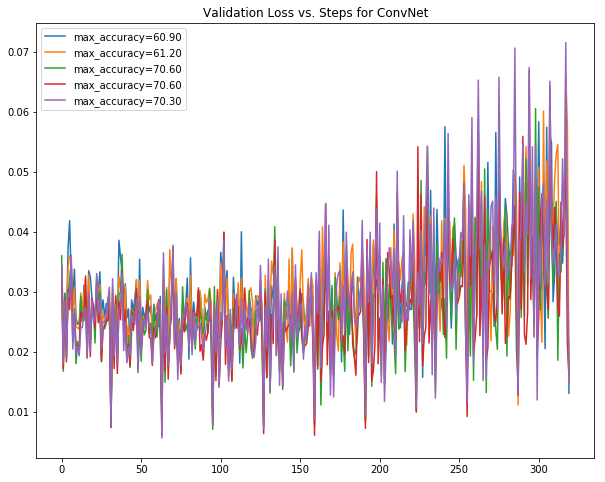

In [177]:
plt.figure(figsize=(10,8))
for row in confs.iterrows():
    plt.plot(row[1]['val_loss_hist'], label='max_accuracy={:.2f}'.format(row[1]['max_val_accuracy']))
plt.legend()
plt.title('Validation Loss vs. Steps for ConvNet')
plt.savefig('plots/val_loss_vs_steps_cnn.png')
plt.show()

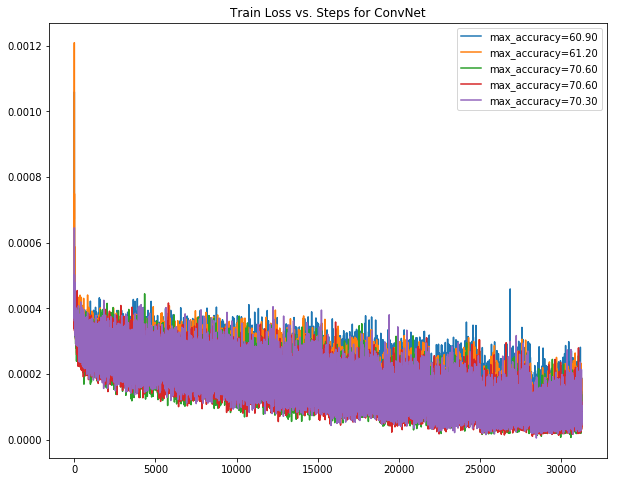

In [178]:
plt.figure(figsize=(10,8))
for row in confs.iterrows():
    plt.plot(row[1]['train_loss_hist'], label='max_accuracy={:.2f}'.format(row[1]['max_val_accuracy']))
plt.legend()
plt.title('Train Loss vs. Steps for ConvNet')
plt.savefig('plots/train_loss_vs_steps_cnn.png')
plt.show()

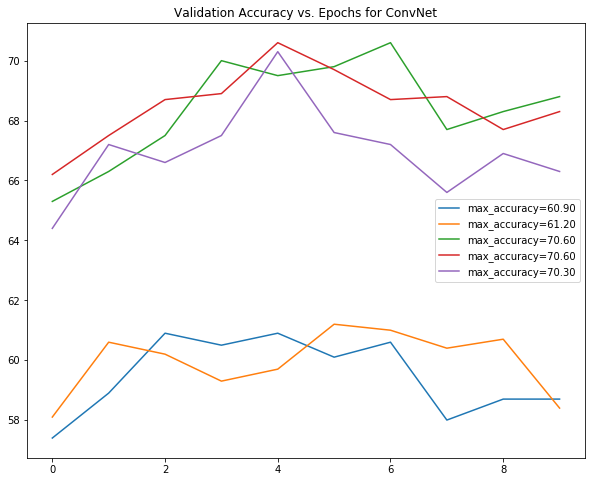

In [179]:
plt.figure(figsize=(10,8))
for row in confs.iterrows():
    plt.plot(row[1]['val_accuracy_hist'], label='max_accuracy={:.2f}'.format(row[1]['max_val_accuracy']))
plt.legend()
plt.title('Validation Accuracy vs. Epochs for ConvNet')
plt.savefig('plots/val_accuracy_vs_epochs_cnn.png')
plt.show()

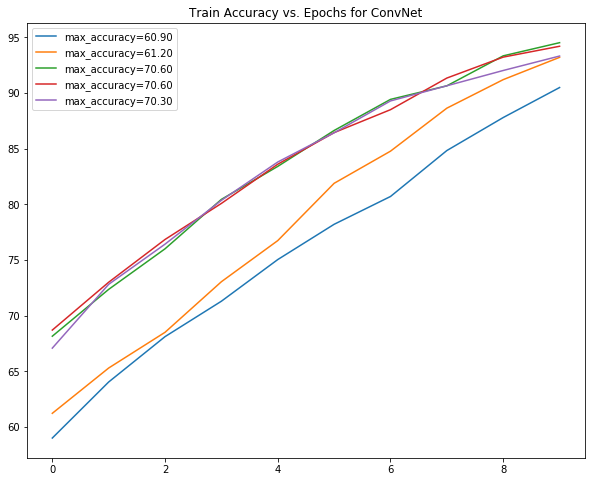

In [180]:
plt.figure(figsize=(10,8))
for row in confs.iterrows():
    plt.plot(row[1]['train_accuracy_hist'], label='max_accuracy={:.2f}'.format(row[1]['max_val_accuracy']))
plt.legend()
plt.title('Train Accuracy vs. Epochs for ConvNet')
plt.savefig('plots/train_accuracy_vs_epochs_cnn.png')
plt.show()

In [255]:
conf_gru = cv_results_gru.drop(['lr', 'class_hidden_size', 'num_params'], axis=1)
conf_gru.head()

,emb_hidden_size,vocab_size,max_sent_length,agg_mode,dropout,train_loss_hist,val_loss_hist,train_accuracy_hist,val_accuracy_hist,max_val_accuracy
0,256,10000,25,cat,0.0,"[1.0521481604003904, 0.9150468886947615, 0.861...","[0.9806990337371827, 0.9010408611297609, 0.849...","[52.692997455596924, 58.50200057029724, 61.816...","[51.20000243186951, 59.00000333786011, 61.8000...",71.700001
1,256,10000,25,cat,0.5,"[1.1057249517631516, 0.9903058735084524, 0.912...","[1.0307063674926755, 0.9276190309524536, 0.897...","[47.11099863052368, 56.616997718811035, 59.466...","[46.00000083446503, 56.00000023841858, 57.2000...",69.300002
2,256,10000,25,sum,0.0,"[1.120934270477293, 1.0545814695167517, 1.0375...","[1.057615077972412, 1.0419543762207035, 1.0165...","[43.95299851894379, 46.06499969959259, 48.7129...","[44.30000185966492, 48.100003600120544, 49.000...",61.200005
3,256,10000,25,sum,0.5,"[1.1420919562339802, 1.096208324775697, 1.0819...","[1.0985206851959228, 1.0928592538833617, 1.067...","[35.56299805641174, 37.75299787521362, 43.8809...","[34.300002455711365, 38.00000250339508, 43.200...",58.000004
4,256,10000,25,elementwise_mult,0.0,"[1.1689635734558104, 1.0191617088890068, 0.939...","[1.059577857017517, 0.9772941179275513, 0.9289...","[44.39999759197235, 52.55599617958069, 56.9289...","[42.500001192092896, 50.90000033378601, 55.099...",69.300002


In [256]:
results_agg_mode = conf_gru.query('vocab_size == @best_conf_gru.vocab_size & emb_hidden_size == @best_conf_gru.emb_hidden_size & max_sent_length == @best_conf_gru.max_sent_length & dropout == @best_conf_gru.dropout')
results_agg_mode

,emb_hidden_size,vocab_size,max_sent_length,agg_mode,dropout,train_loss_hist,val_loss_hist,train_accuracy_hist,val_accuracy_hist,max_val_accuracy
6,256,10000,50,cat,0.0,"[1.0598852623748791, 0.9169351967811601, 0.860...","[0.9724318923950197, 0.8908178215026856, 0.839...","[53.39699983596802, 59.04799699783325, 62.0079...","[52.60000228881836, 57.70000219345093, 61.0000...",73.000002
8,256,10000,50,sum,0.0,"[1.1192617325782788, 1.0603208077240007, 1.039...","[1.0713802499771117, 1.0457488927841185, 1.016...","[42.645999789237976, 45.273998379707336, 48.90...","[44.200003147125244, 45.40000259876251, 48.900...",61.100000
10,256,10000,50,elementwise_mult,0.0,"[1.194256053066254, 1.0268304273605333, 0.9433...","[1.0839153547286986, 0.9615317668914796, 0.921...","[42.78499782085419, 52.2130012512207, 57.14899...","[43.90000104904175, 52.900004386901855, 55.900...",68.300003


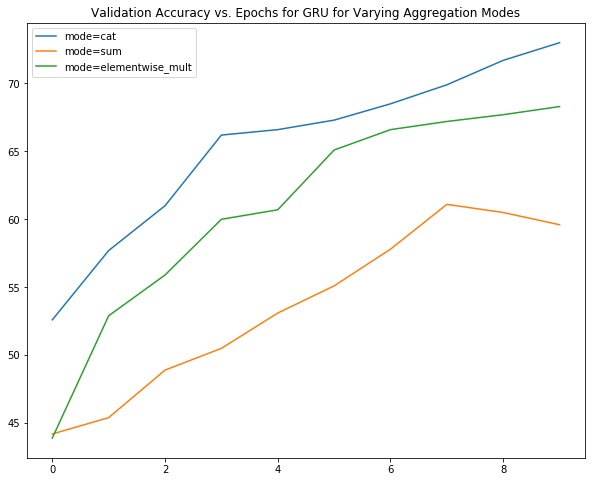

In [257]:
plt.figure(figsize=(10,8))
for row in results_agg_mode.iterrows():
    plt.plot(row[1]['val_accuracy_hist'], label='mode={}'.format(row[1]['agg_mode']))
plt.legend()
plt.title('Validation Accuracy vs. Epochs for GRU for Varying Aggregation Modes')
plt.savefig('plots/val_accuracy_vs_agg_mode.png')
plt.show()

In [258]:
results_vocab_size = conf_gru.query('agg_mode == @best_conf_gru.agg_mode & emb_hidden_size == @best_conf_gru.emb_hidden_size & max_sent_length == @best_conf_gru.max_sent_length & dropout == @best_conf_gru.dropout')
results_vocab_size

,emb_hidden_size,vocab_size,max_sent_length,agg_mode,dropout,train_loss_hist,val_loss_hist,train_accuracy_hist,val_accuracy_hist,max_val_accuracy
6,256,10000,50,cat,0.0,"[1.0598852623748791, 0.9169351967811601, 0.860...","[0.9724318923950197, 0.8908178215026856, 0.839...","[53.39699983596802, 59.04799699783325, 62.0079...","[52.60000228881836, 57.70000219345093, 61.0000...",73.000002
18,256,50000,50,cat,0.0,"[1.0416193476676936, 0.9077274583435061, 0.854...","[0.963697407722473, 0.9004036903381349, 0.8540...","[55.18699884414673, 58.980000019073486, 62.490...","[54.80000376701355, 58.70000123977661, 60.7000...",70.900005


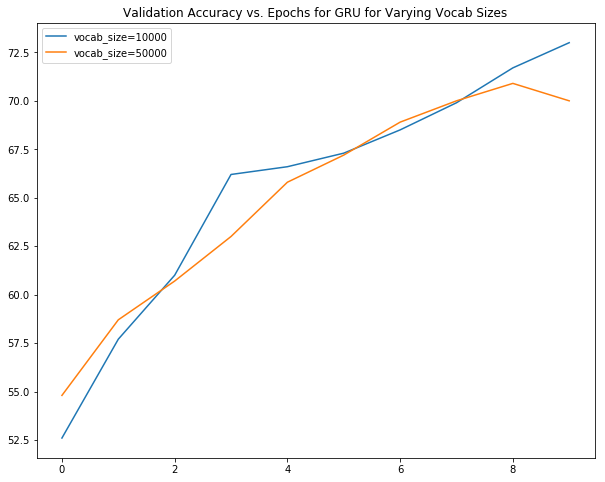

In [259]:
plt.figure(figsize=(10,8))
for row in results_vocab_size.iterrows():
    plt.plot(row[1]['val_accuracy_hist'], label='vocab_size={}'.format(row[1]['vocab_size']))
plt.legend()
plt.title('Validation Accuracy vs. Epochs for GRU for Varying Vocab Sizes')
plt.savefig('plots/val_accuracy_vs_vocab_size.png')
plt.show()

In [260]:
results_emb_hidden_size = conf_gru.query('agg_mode == @best_conf_gru.agg_mode & vocab_size == @best_conf_gru.vocab_size & max_sent_length == @best_conf_gru.max_sent_length & dropout == @best_conf_gru.dropout')
results_emb_hidden_size

,emb_hidden_size,vocab_size,max_sent_length,agg_mode,dropout,train_loss_hist,val_loss_hist,train_accuracy_hist,val_accuracy_hist,max_val_accuracy
6,256,10000,50,cat,0.0,"[1.0598852623748791, 0.9169351967811601, 0.860...","[0.9724318923950197, 0.8908178215026856, 0.839...","[53.39699983596802, 59.04799699783325, 62.0079...","[52.60000228881836, 57.70000219345093, 61.0000...",73.000002
30,512,10000,50,cat,0.0,"[1.0533180903816215, 0.9201868204879748, 0.859...","[0.9660212783813477, 0.9008252592086794, 0.849...","[54.16799783706665, 58.32799673080444, 62.1230...","[53.800004720687866, 58.000004291534424, 61.30...",69.800001


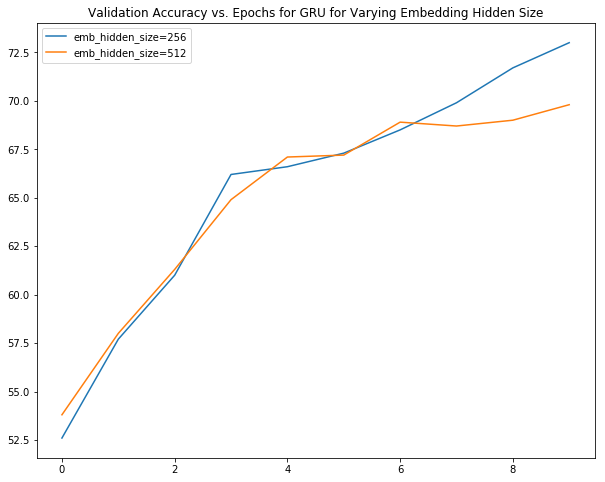

In [261]:
plt.figure(figsize=(10,8))
for row in results_emb_hidden_size.iterrows():
    plt.plot(row[1]['val_accuracy_hist'], label='emb_hidden_size={}'.format(row[1]['emb_hidden_size']))
plt.legend()
plt.title('Validation Accuracy vs. Epochs for GRU for Varying Embedding Hidden Size')
plt.savefig('plots/val_accuracy_vs_emb_hidden_size.png')
plt.show()

In [262]:
results_dropout = conf_gru.query('agg_mode == @best_conf_gru.agg_mode & vocab_size == @best_conf_gru.vocab_size & max_sent_length == @best_conf_gru.max_sent_length & emb_hidden_size == @best_conf_gru.emb_hidden_size')
results_dropout

,emb_hidden_size,vocab_size,max_sent_length,agg_mode,dropout,train_loss_hist,val_loss_hist,train_accuracy_hist,val_accuracy_hist,max_val_accuracy
6,256,10000,50,cat,0.0,"[1.0598852623748791, 0.9169351967811601, 0.860...","[0.9724318923950197, 0.8908178215026856, 0.839...","[53.39699983596802, 59.04799699783325, 62.0079...","[52.60000228881836, 57.70000219345093, 61.0000...",73.000002
7,256,10000,50,cat,0.5,"[1.1031433493041987, 0.9856468642044046, 0.913...","[1.0290873680114747, 0.9268091058731079, 0.890...","[48.32799732685089, 56.692999601364136, 59.560...","[46.50000333786011, 55.50000071525574, 59.0000...",70.200002


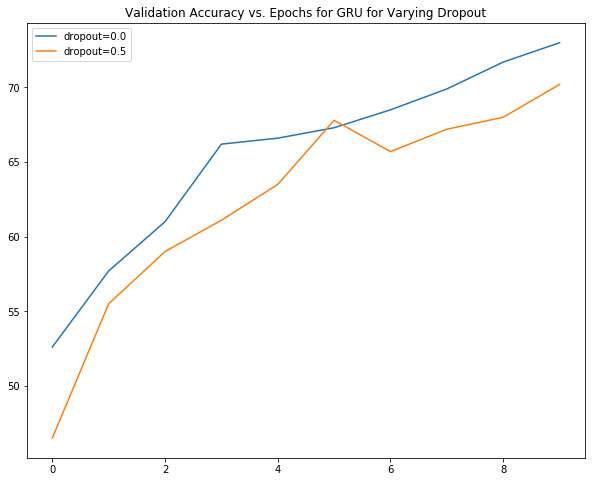

In [263]:
plt.figure(figsize=(10,8))
for row in results_dropout.iterrows():
    plt.plot(row[1]['val_accuracy_hist'], label='dropout={}'.format(row[1]['dropout']))
plt.legend()
plt.title('Validation Accuracy vs. Epochs for GRU for Varying Dropout')
plt.savefig('plots/val_accuracy_vs_dropout.png')
plt.show()

In [264]:
results_max_sent_length = conf_gru.query('agg_mode == @best_conf_gru.agg_mode & vocab_size == @best_conf_gru.vocab_size & dropout == @best_conf_gru.dropout & emb_hidden_size == @best_conf_gru.emb_hidden_size')
results_max_sent_length

,emb_hidden_size,vocab_size,max_sent_length,agg_mode,dropout,train_loss_hist,val_loss_hist,train_accuracy_hist,val_accuracy_hist,max_val_accuracy
0,256,10000,25,cat,0.0,"[1.0521481604003904, 0.9150468886947615, 0.861...","[0.9806990337371827, 0.9010408611297609, 0.849...","[52.692997455596924, 58.50200057029724, 61.816...","[51.20000243186951, 59.00000333786011, 61.8000...",71.700001
6,256,10000,50,cat,0.0,"[1.0598852623748791, 0.9169351967811601, 0.860...","[0.9724318923950197, 0.8908178215026856, 0.839...","[53.39699983596802, 59.04799699783325, 62.0079...","[52.60000228881836, 57.70000219345093, 61.0000...",73.000002


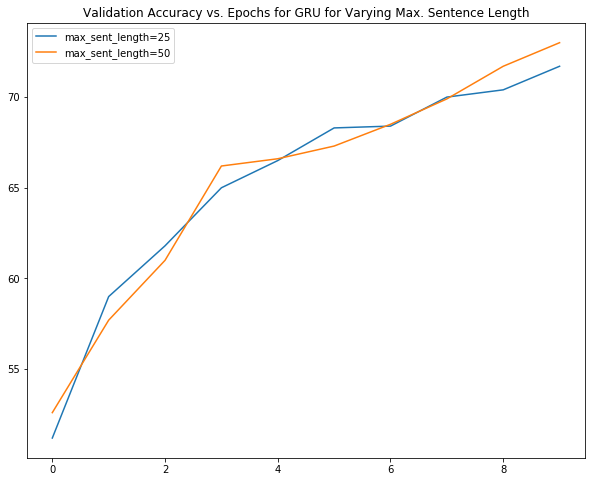

In [265]:
plt.figure(figsize=(10,8))
for row in results_max_sent_length.iterrows():
    plt.plot(row[1]['val_accuracy_hist'], label='max_sent_length={}'.format(row[1]['max_sent_length']))
plt.legend()
plt.title('Validation Accuracy vs. Epochs for GRU for Varying Max. Sentence Length')
plt.savefig('plots/val_accuracy_vs_max_sent_length.png')
plt.show()

In [270]:
# Best configuration
conf_gru = cv_gru.loc[cv_gru['max_val_accuracy'] == cv_gru['max_val_accuracy'].max()].iloc[0]

In [271]:
conf_gru

hidden_size                                                        200
interaction_type                                                concat
train_loss_hist      [1.6580356359481812, 1.5738856792449951, 2.460...
val_acc_hist         [38.3, 35.6, 36.1, 39.8, 37.1, 42.1, 41.9, 40....
max_val_acc                                                         73
max_val_acc_epoch                                                  307
Name: 0, dtype: object

In [273]:
confs = cv_gru.sort_values(by='max_val_accuracy').iloc[[0,1]+[-1,-2,-3]]

In [274]:
confs

,hidden_size,interaction_type,train_loss_hist,val_acc_hist,max_val_acc,max_val_acc_epoch
1,200,mul,"[2.2173616886138916, 2.8239927291870117, 2.109...","[33.0, 34.0, 34.8, 33.1, 33.9, 35.0, 39.2, 35....",68.9,290
3,512,mul,"[2.4888150691986084, 2.2027552127838135, 2.233...","[32.9, 34.2, 35.5, 33.9, 34.6, 34.8, 37.1, 36....",70.2,310
0,200,concat,"[1.6580356359481812, 1.5738856792449951, 2.460...","[38.3, 35.6, 36.1, 39.8, 37.1, 42.1, 41.9, 40....",73,307
2,512,concat,"[2.178666830062866, 2.4267079830169678, 2.4710...","[37.0, 35.2, 37.7, 41.0, 39.5, 36.3, 40.9, 41....",72.5,313
3,512,mul,"[2.4888150691986084, 2.2027552127838135, 2.233...","[32.9, 34.2, 35.5, 33.9, 34.6, 34.8, 37.1, 36....",70.2,310


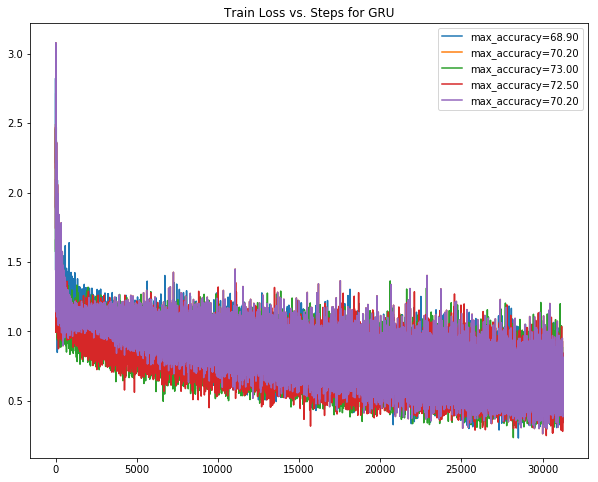

In [279]:
plt.figure(figsize=(10,8))
for row in confs.iterrows():
    plt.plot(row[1]['train_loss_hist'], label='max_accuracy={:.2f}'.format(row[1]['max_val_accuracy']))
plt.legend()
plt.title('Train Loss vs. Steps for GRU')
plt.savefig('plots/train_loss_vs_steps_gru.png')
plt.show()

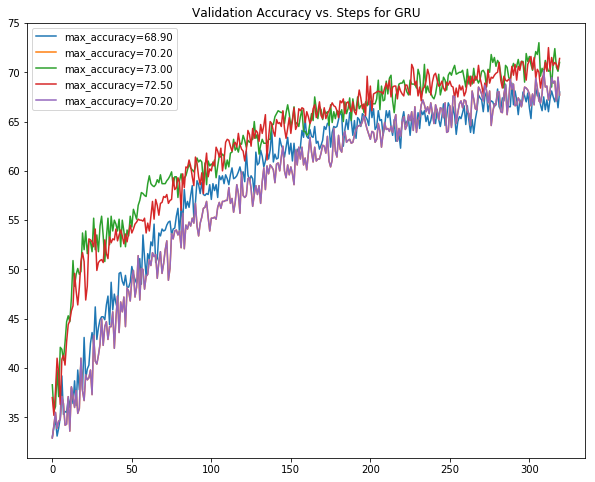

In [283]:
plt.figure(figsize=(10,8))
for row in confs.iterrows():
    plt.plot(row[1]['val_accuracy_hist'], label='max_accuracy={:.2f}'.format(row[1]['max_val_accuracy']))
plt.legend()
plt.title('Validation Accuracy vs. Steps for GRU')
plt.savefig('plots/val_accuracy_vs_steps_gru.png')
plt.show()